In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
h5='/Volumes/molly/20220511alltrials_LD.h5'

In [3]:
df=pd.read_hdf(h5, key='df')

In [4]:
df

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000
2,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[21.715381070777248, 21.721281588786553, 21.72...","[0.36074291483611154, 0.7115064917078303, 0.80...","[0.16767258394997434, 0.1256581066396896, 0.21...","[148.76262093536454, 148.38440970340278, 148.3...",198.720,0.050321,6.185,0.400000,0.250000
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.5382088253352006, 3.5579035878841205, 3.516...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",34.945,0.277598,0.060,0.333333,0.200000
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000


In [16]:
df['filename']=df['filename'].astype('str')

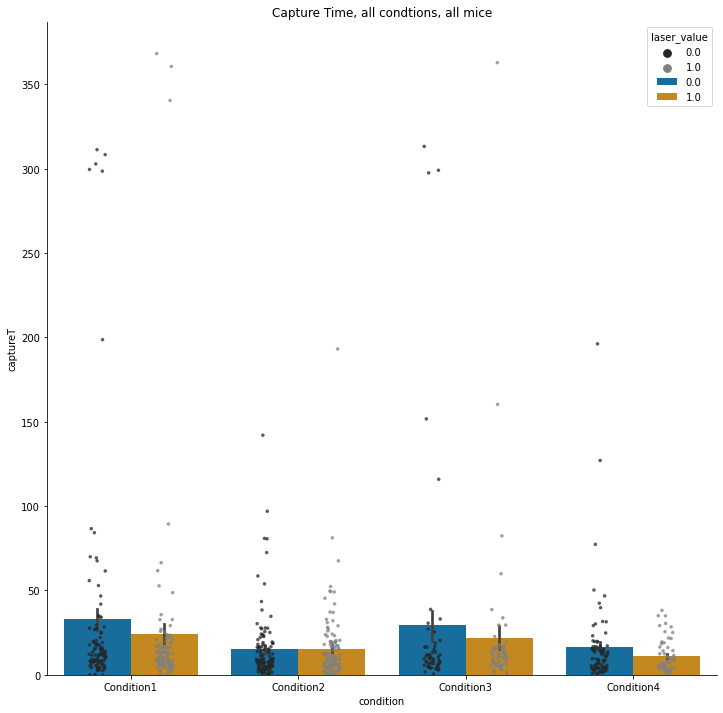

In [36]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75)
plt.title('Capture Time, all condtions, all mice')
# plt.ylim(0,100)
# plt.yticks(np.arange(0,100,10))
sns.despine()

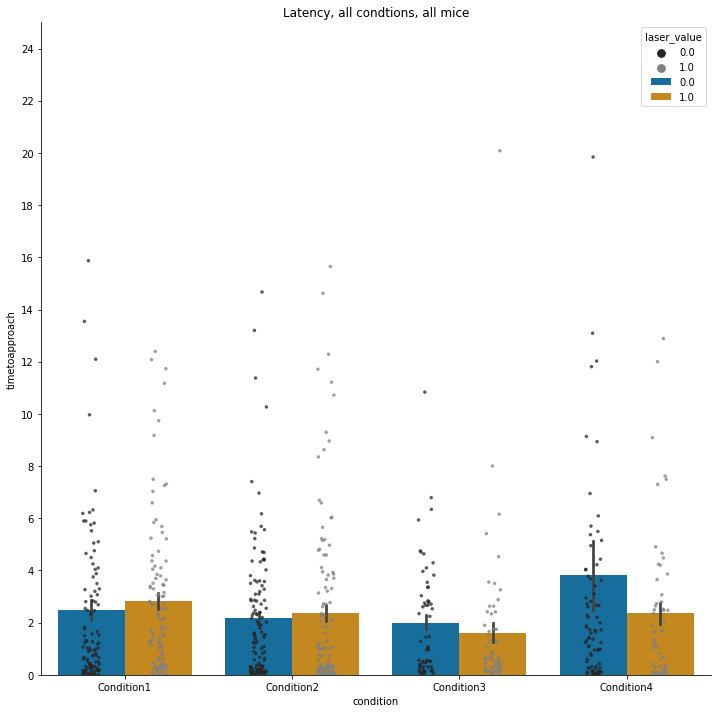

In [10]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df, x='condition', y='timetoapproach', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='timetoapproach', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75)
plt.title('Latency, all condtions, all mice')
plt.ylim(0,25)
plt.yticks(np.arange(0,25,2))
sns.despine()

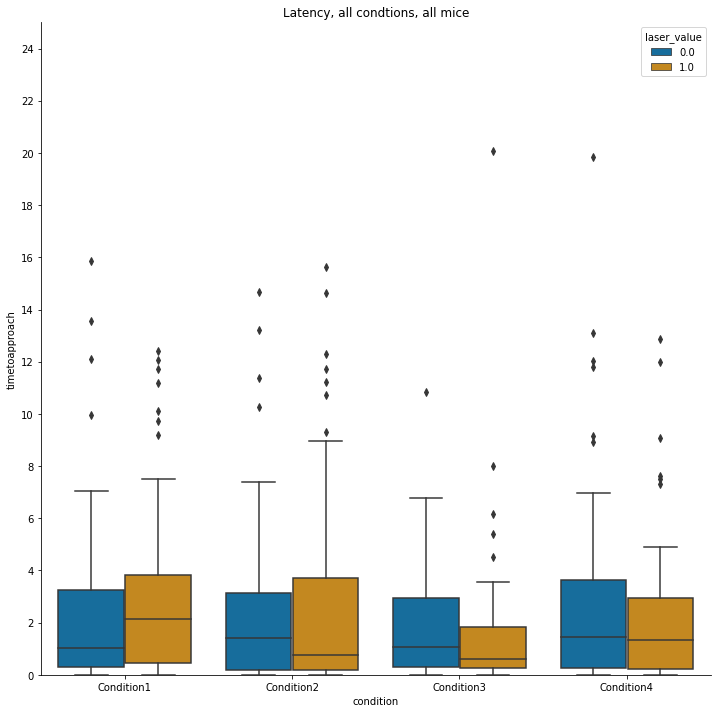

In [11]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df, x='condition', y='timetoapproach', hue='laser_value',  palette="colorblind")
# ax= sns.stripplot(x='condition', y='timetoapproach', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75)
plt.title('Latency, all condtions, all mice')
plt.ylim(0,25)
plt.yticks(np.arange(0,25,2))
sns.despine()

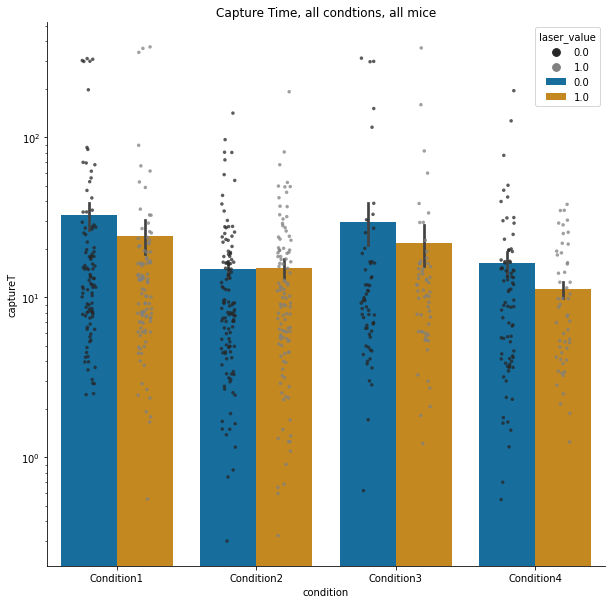

In [12]:
plt.figure(figsize=(10,10))
ax=sns.barplot(data=df, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75)
ax.set_yscale('log')
plt.title('Capture Time, all condtions, all mice')
# plt.ylim(0,50)
sns.despine()

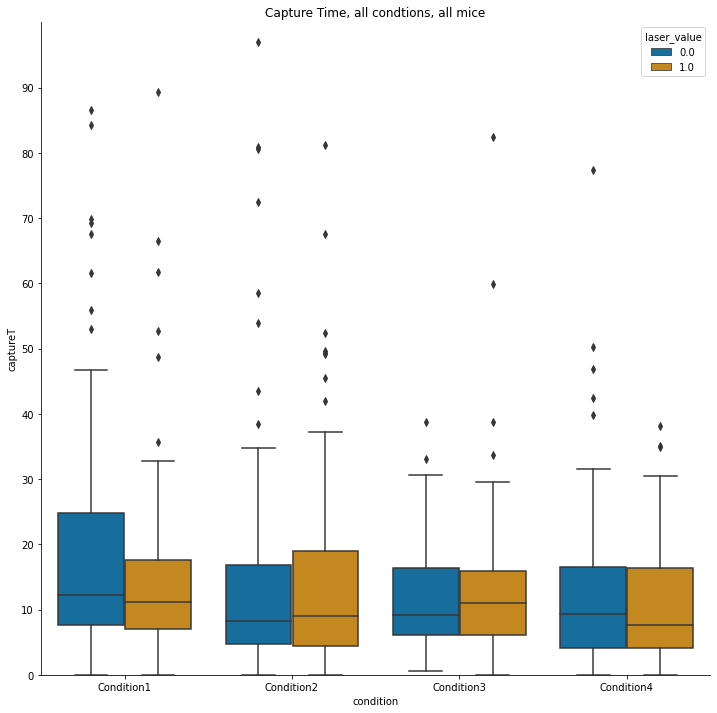

In [13]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df, x='condition', y='captureT', hue='laser_value', palette="colorblind")
plt.title('Capture Time, all condtions, all mice')
plt.ylim(0,100)
plt.yticks(np.arange(0,100,10))
# ax.set_yscale('log')
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5)
sns.despine()

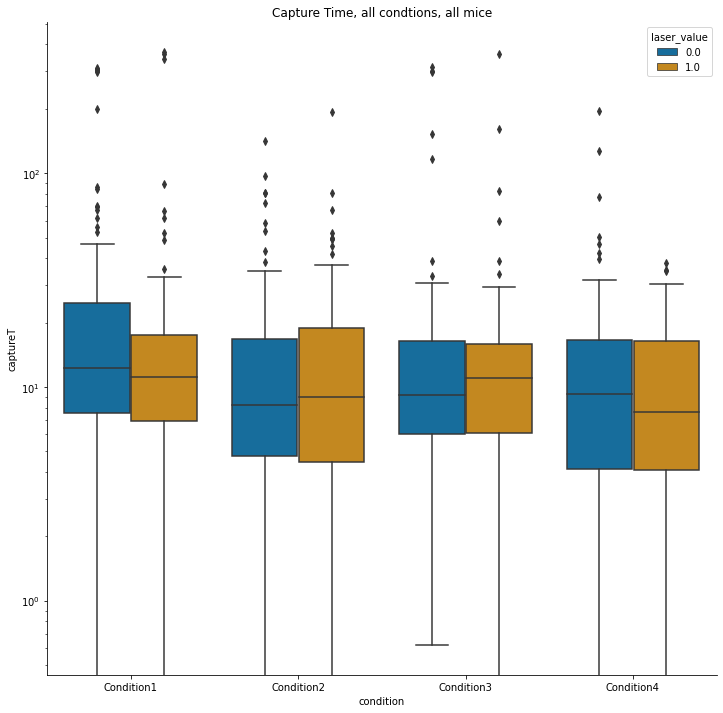

In [14]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df, x='condition', y='captureT', hue='laser_value', palette="colorblind")
ax.set_yscale('log')
plt.title('Capture Time, all condtions, all mice')
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5)
sns.despine()

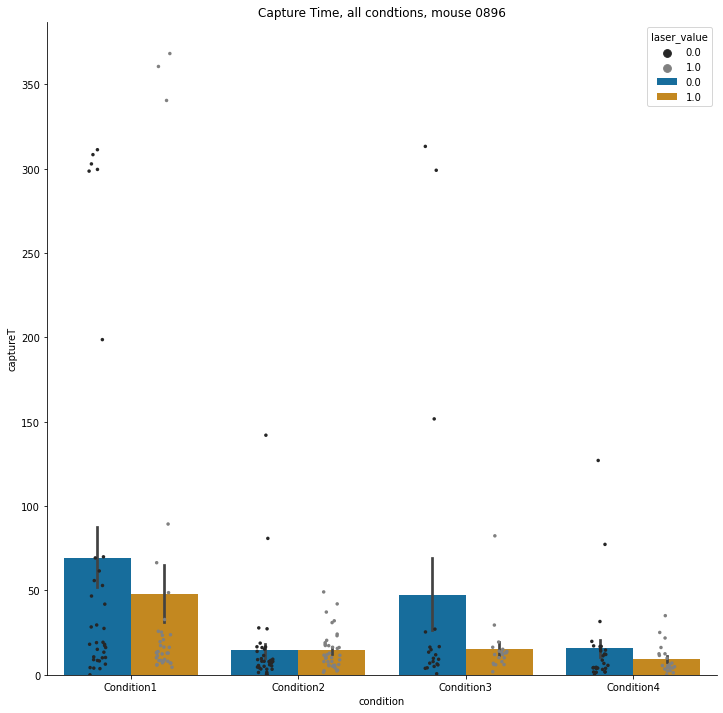

In [16]:
df['filename']=df['filename'].astype('str')
df0896=df[df['filename'].str.contains('0896')]
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df0896, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5)
# # plt.ylim(0,50)
plt.title('Capture Time, all condtions, mouse 0896')
sns.despine()

In [17]:
df0896

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000
2,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[21.715381070777248, 21.721281588786553, 21.72...","[0.36074291483611154, 0.7115064917078303, 0.80...","[0.16767258394997434, 0.1256581066396896, 0.21...","[148.76262093536454, 148.38440970340278, 148.3...",198.720,0.050321,6.185,0.400000,0.250000
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[11.865312396373886, 13.241495111195926, 14.35...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",6.965,0.099034,2.790,0.250000,1.000000
700,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.4527342519468733, 1.5778002732348897, 1.746...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.240,0.101587,0.075,0.250000,1.000000
701,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[11.00310606766738, 13.704135400263457, 16.247...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",11.480,0.161929,0.035,0.555556,0.200000
702,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[9.180225662925693, 10.100061265704785, 10.434...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",2.165,0.084087,0.135,0.500000,1.000000


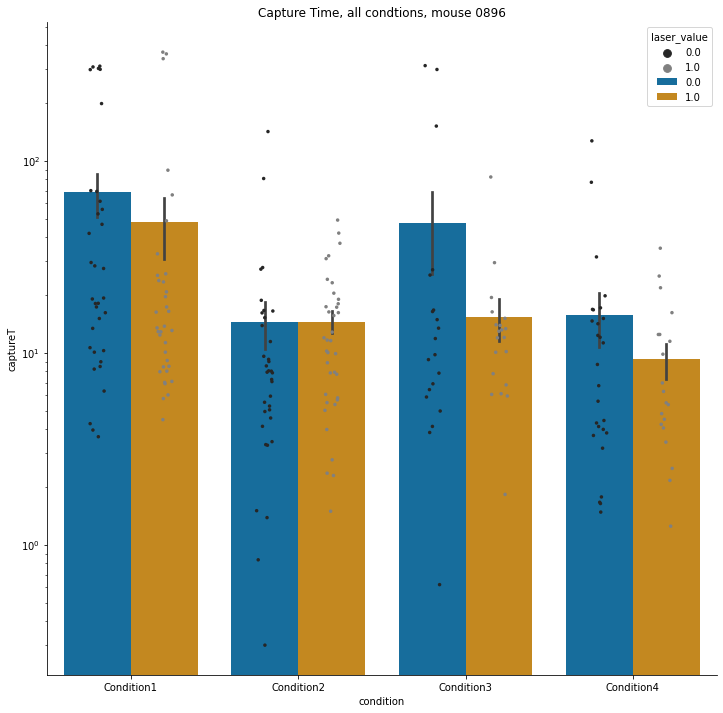

In [18]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df0896, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5)
ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0896')
sns.despine()

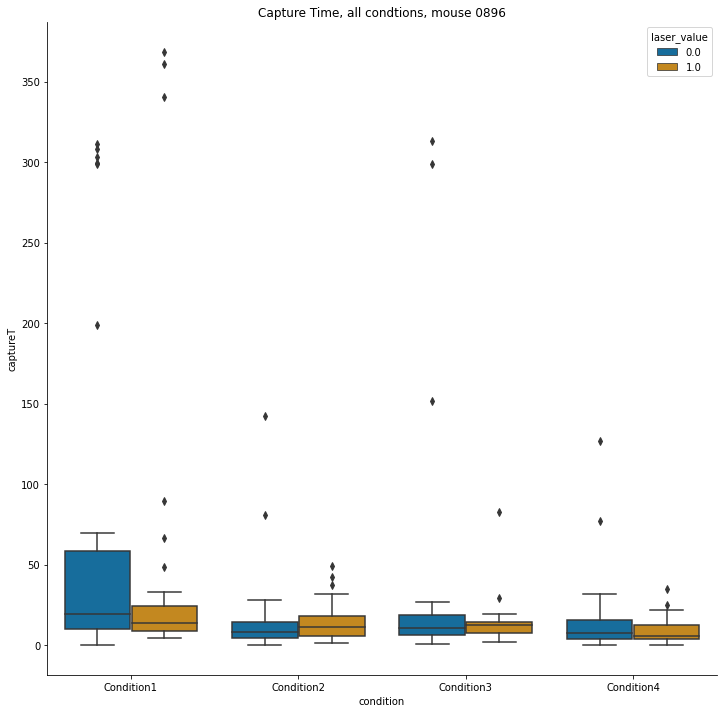

In [19]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df0896, x='condition', y='captureT', hue='laser_value', palette="colorblind")
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5)
# ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0896')
sns.despine()

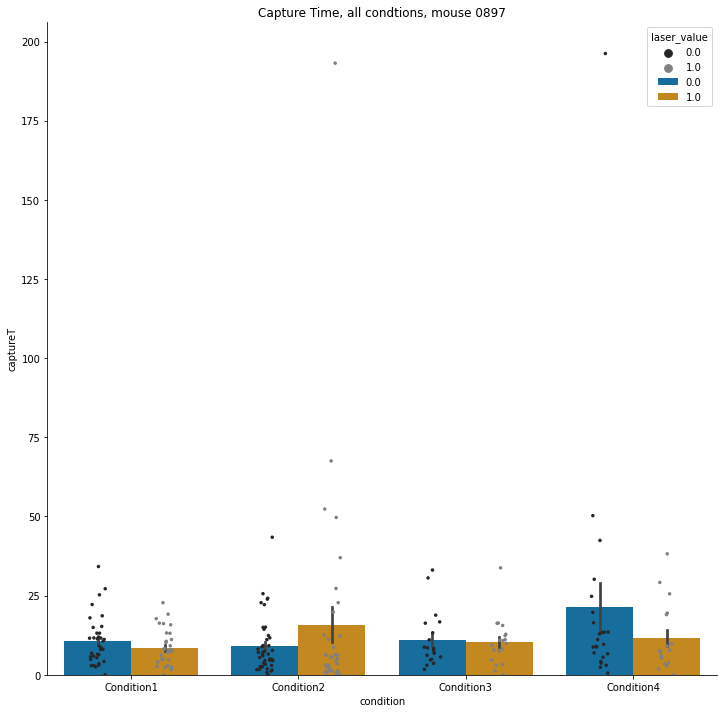

In [20]:
df0897=df[df['filename'].str.contains('0897')]
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df0897, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0897, color='gray', size=3.5)
plt.title('Capture Time, all condtions, mouse 0897')
# # plt.ylim(0,50)
sns.despine()

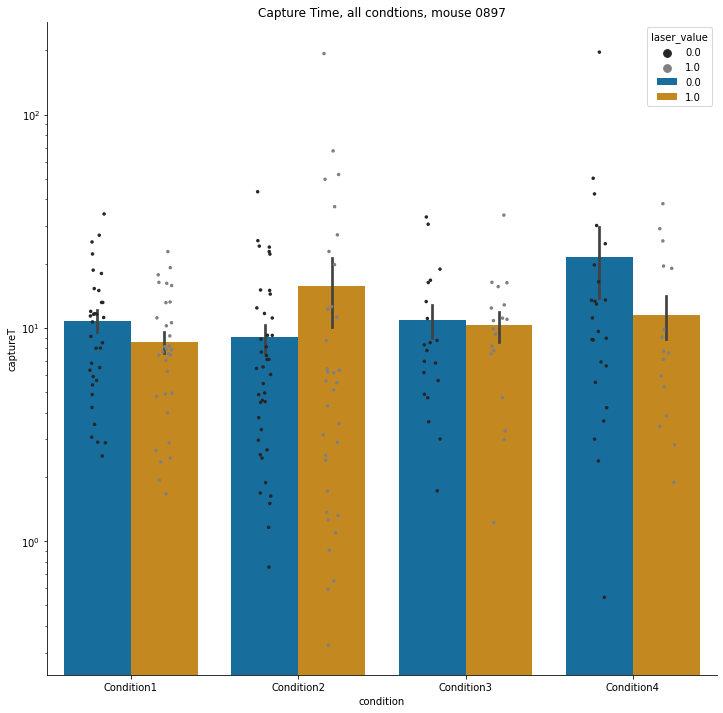

In [21]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df0897, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0897, color='gray', size=3.5)
ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0897')
sns.despine()

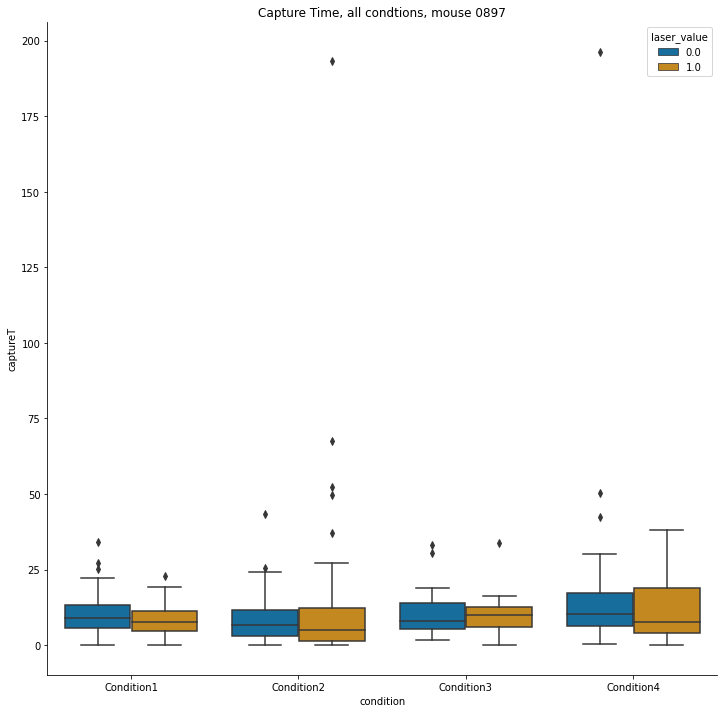

In [22]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df0897, x='condition', y='captureT', hue='laser_value', palette="colorblind")
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5)
# ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0897')
sns.despine()

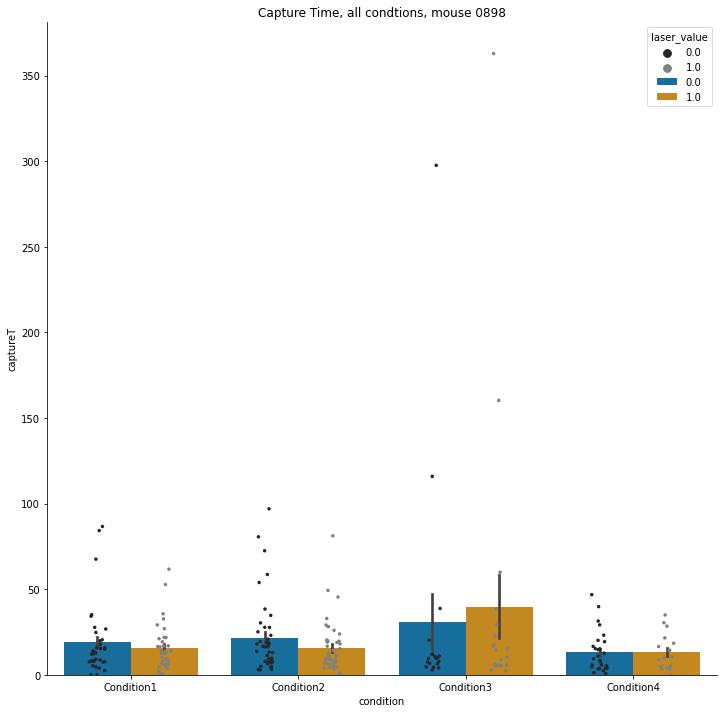

In [23]:
df0898=df[df['filename'].str.contains('0898')]
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df0898, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0898, color='gray', size=3.5)
# # plt.ylim(0,50)
plt.title('Capture Time, all condtions, mouse 0898')
sns.despine()

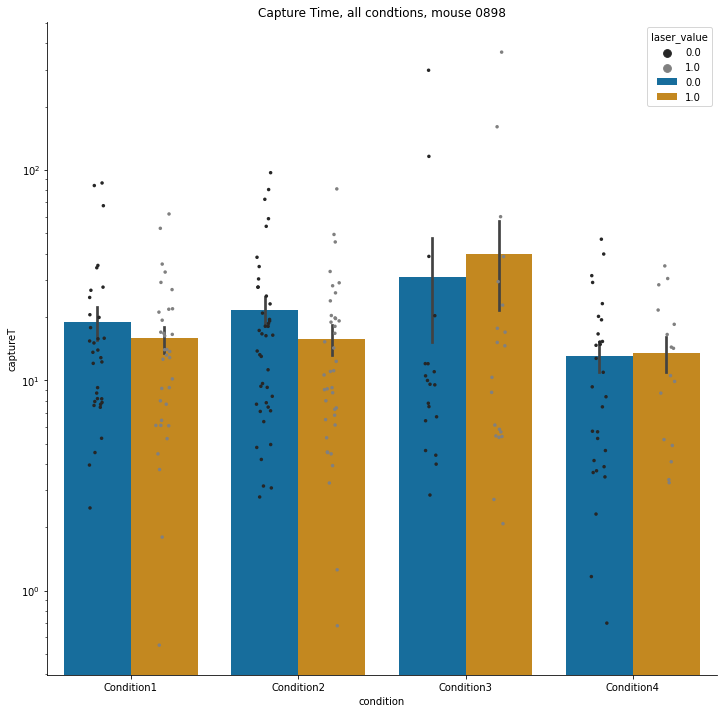

In [24]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df0898, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0898, color='gray', size=3.5)
ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0898')
sns.despine()

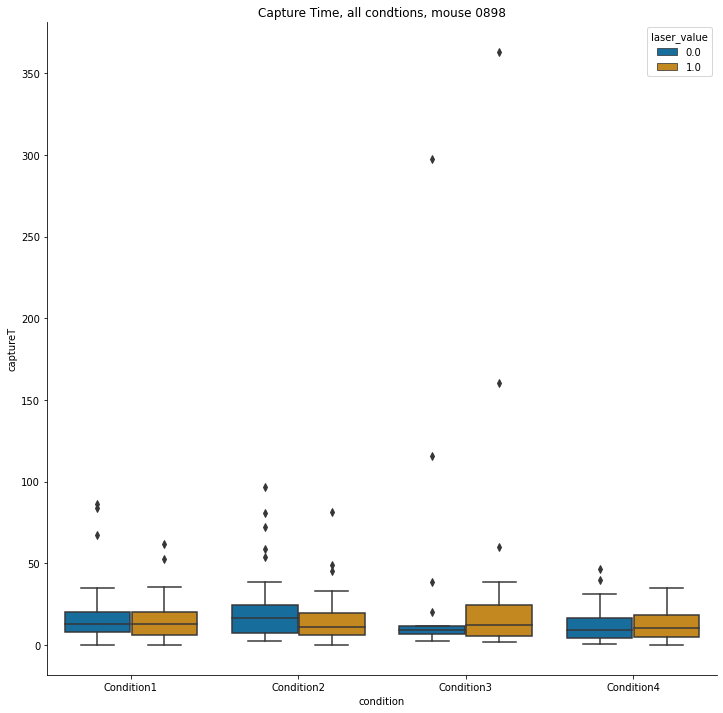

In [25]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df0898, x='condition', y='captureT', hue='laser_value', palette="colorblind")
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5)
# ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0898')
sns.despine()

In [6]:
df['filename']=df['filename'].astype('str')
type(df['filename'][0])

str

In [7]:
mean_df=df.groupby(['condition','laser_value']).median()
mean_df

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                       
Condition1 0.0           12.2150      0.132617           1.025    0.666667   
           1.0           11.1400      0.107009           2.120    0.857143   
Condition2 0.0            8.2625      0.109432           1.425    0.600000   
           1.0            8.9450      0.094250           0.750    0.519231   
Condition3 0.0            9.2150      0.102987           1.070    0.800000   
           1.0           10.9600      0.115490           0.600    0.800000   
Condition4 0.0            9.3000      0.080096           1.430    0.666667   
           1.0            7.6250      0.079208           1.345    0.555556   

                        prob_capture  
condition  laser_value                
Condition1 0.0              0.333333  
           1.0              0.333333  
Condition2 0.0              0.500000  
           1.0              1.000000  
Condition3 0.0              0.333333  
           1.0              0.333333  
Condition4 0.0              0.500000  
           1.0              0.500000

In [43]:
test=df[['condition', 'laser_value', 'mouse_spd']]
test

,condition,laser_value,mouse_spd
0,Condition1,0.0,"[14.012931903926157, 16.45841103998438, 19.185..."
1,Condition1,0.0,"[10.771332386653675, 11.611506992090918, 12.79..."
2,Condition1,0.0,"[0.16767258394997434, 0.1256581066396896, 0.21..."
4,Condition1,0.0,"[0.41138057161378183, 0.5378076393260555, 0.72..."
5,Condition1,0.0,"[8.876253093269236, 9.447072818341788, 9.96988..."
...,...,...,...
735,Condition4,1.0,"[3.5382088253352006, 3.5579035878841205, 3.516..."
737,Condition4,1.0,"[1.462482842239078, 1.488112138526609, 1.60963..."
738,Condition4,1.0,"[12.066814973701607, 13.87237568286862, 16.108..."
739,Condition4,1.0,"[0.5426251488004638, 0.6258404237519565, 0.650..."


In [55]:
nonan=test.dropna()
nonan

,condition,laser_value,mouse_spd
0,Condition1,0.0,"[14.012931903926157, 16.45841103998438, 19.185..."
1,Condition1,0.0,"[10.771332386653675, 11.611506992090918, 12.79..."
2,Condition1,0.0,"[0.16767258394997434, 0.1256581066396896, 0.21..."
4,Condition1,0.0,"[0.41138057161378183, 0.5378076393260555, 0.72..."
5,Condition1,0.0,"[8.876253093269236, 9.447072818341788, 9.96988..."
...,...,...,...
735,Condition4,1.0,"[3.5382088253352006, 3.5579035878841205, 3.516..."
737,Condition4,1.0,"[1.462482842239078, 1.488112138526609, 1.60963..."
738,Condition4,1.0,"[12.066814973701607, 13.87237568286862, 16.108..."
739,Condition4,1.0,"[0.5426251488004638, 0.6258404237519565, 0.650..."


In [6]:
from copy import deepcopy as cdc

In [17]:
df

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000
2,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[21.715381070777248, 21.721281588786553, 21.72...","[0.36074291483611154, 0.7115064917078303, 0.80...","[0.16767258394997434, 0.1256581066396896, 0.21...","[148.76262093536454, 148.38440970340278, 148.3...",198.720,0.050321,6.185,0.400000,0.250000
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.5382088253352006, 3.5579035878841205, 3.516...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",34.945,0.277598,0.060,0.333333,0.200000
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000


In [18]:
copydf=cdc(df)
copydf['captureT'][copydf['captureT']>=300]=np.nan

<ipython-input-18-d3a753230c46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copydf['captureT'][copydf['captureT']>=300]=np.nan


In [19]:
copydf

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000
2,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[21.715381070777248, 21.721281588786553, 21.72...","[0.36074291483611154, 0.7115064917078303, 0.80...","[0.16767258394997434, 0.1256581066396896, 0.21...","[148.76262093536454, 148.38440970340278, 148.3...",198.720,0.050321,6.185,0.400000,0.250000
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.5382088253352006, 3.5579035878841205, 3.516...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",34.945,0.277598,0.060,0.333333,0.200000
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000


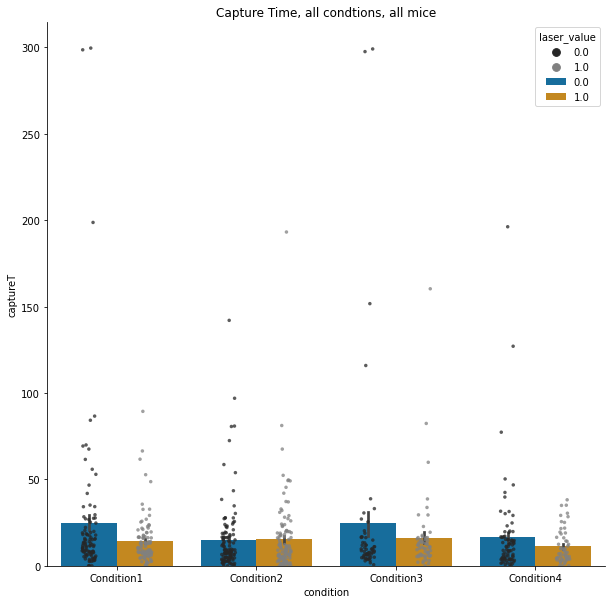

In [11]:
plt.figure(figsize=(10,10))
ax=sns.barplot(data=copydf, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind")
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=copydf, color='gray', size=3.5, alpha=0.75)
plt.title('Capture Time, all condtions, all mice')
# ax.set_yscale('log')
sns.despine()

In [12]:
mean_copydf=copydf.groupby(['condition','laser_value']).mean()
mean_copydf

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                        
Condition1 0.0          24.792794      0.140954        2.476762    0.650588   
           1.0          14.429750      0.115506        2.830340    0.770205   
Condition2 0.0          15.032625      0.117598        2.161458    0.658300   
           1.0          15.337675      0.107697        2.378684    0.627408   
Condition3 0.0          24.902414      0.120615        2.000085    0.753376   
           1.0          16.154914      0.125753        1.614746    0.750816   
Condition4 0.0          16.470000      0.100648        3.823333    0.691034   
           1.0          11.277818      0.092408        2.359000    0.607886   

                        prob_capture  
condition  laser_value                
Condition1 0.0              0.453326  
           1.0              0.496875  
Condition2 0.0              0.662666  
           1.0              0.647536  
Condition3 0.0              0.502096  
           1.0              0.413908  
Condition4 0.0              0.599123  
           1.0              0.623485

In [13]:
med_copydf=copydf.groupby(['condition','laser_value']).median()
med_copydf

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                       
Condition1 0.0           11.9825      0.132617           1.025    0.666667   
           1.0           10.3925      0.107009           2.120    0.857143   
Condition2 0.0            8.2625      0.109432           1.425    0.600000   
           1.0            8.9450      0.094250           0.750    0.519231   
Condition3 0.0            8.9725      0.102987           1.070    0.800000   
           1.0           10.8850      0.115490           0.600    0.800000   
Condition4 0.0            9.3000      0.080096           1.430    0.666667   
           1.0            7.6250      0.079208           1.345    0.555556   

                        prob_capture  
condition  laser_value                
Condition1 0.0              0.333333  
           1.0              0.333333  
Condition2 0.0              0.500000  
           1.0              1.000000  
Condition3 0.0              0.333333  
           1.0              0.333333  
Condition4 0.0              0.500000  
           1.0              0.500000

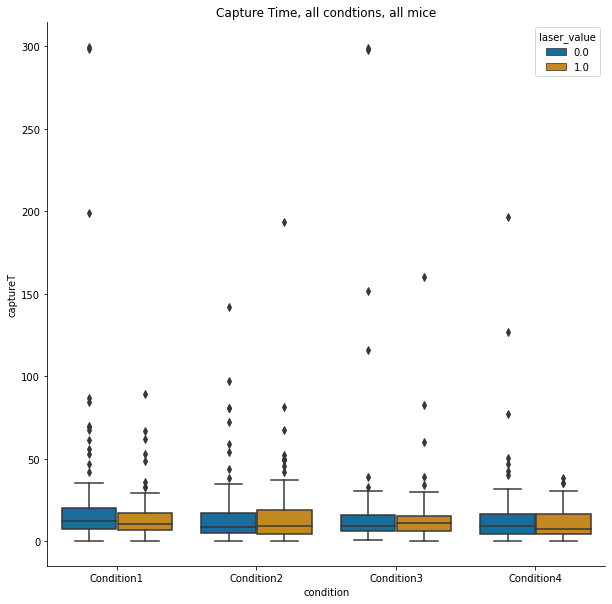

In [14]:
plt.figure(figsize=(10,10))
ax=sns.boxplot(data=copydf, x='condition', y='captureT', hue='laser_value', palette="colorblind")
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=copydf, color='gray', size=3.5, alpha=0.75)
plt.title('Capture Time, all condtions, all mice')
# ax.set_yscale('log')
sns.despine()

In [14]:
from datetime import datetime as dt
import re
def extract_timestamps(series:pd.Series) -> pd.Series:
    timestamp = series.str.extract('_(\d{4}-[\-\d_T]*)DLC', expand=False)
    return pd.to_datetime(timestamp, format="%Y-%m-%dT%H_%M_%S")
##need to have filename column as type str in order for datetime extraction to be used, won't run on Posix type

In [20]:
copydf['timestamps']=extract_timestamps(copydf['filename'])
copydf=copydf.sort_values(by=['condition', 'laser_value','timestamps'])
copydf['sessionID']=ids
copydf

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture,timestamps,sessionID
71,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, 9.988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",24.740,0.241513,0.210,0.888889,0.125000,2022-02-22 08:09:38,0
73,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.9435794273233826, 2.3150358818697847, 2.623...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",3.950,0.105876,0.900,1.000000,0.333333,2022-02-22 08:22:39,1
74,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.5840676417588357, 1.5447335323554987, 1.731...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",15.035,0.107831,3.290,0.666667,0.500000,2022-02-22 08:24:46,2
75,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.0990857586588967, 1.8790604197626206, 1.063...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",26.765,0.182732,0.260,0.571429,0.250000,2022-02-22 08:32:47,3
76,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[4.504542091130307, 4.687903667629036, 4.95473...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",86.640,0.166806,0.265,0.411765,0.142857,2022-02-22 08:35:13,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.279324311771368, 1.241758894488447, 1.30658...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.250,0.022632,0.230,1.000000,1.000000,2022-04-15 09:04:34,50
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333,2022-04-15 09:26:51,51
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000,2022-04-15 09:30:48,52
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000,2022-04-15 09:34:46,53


()

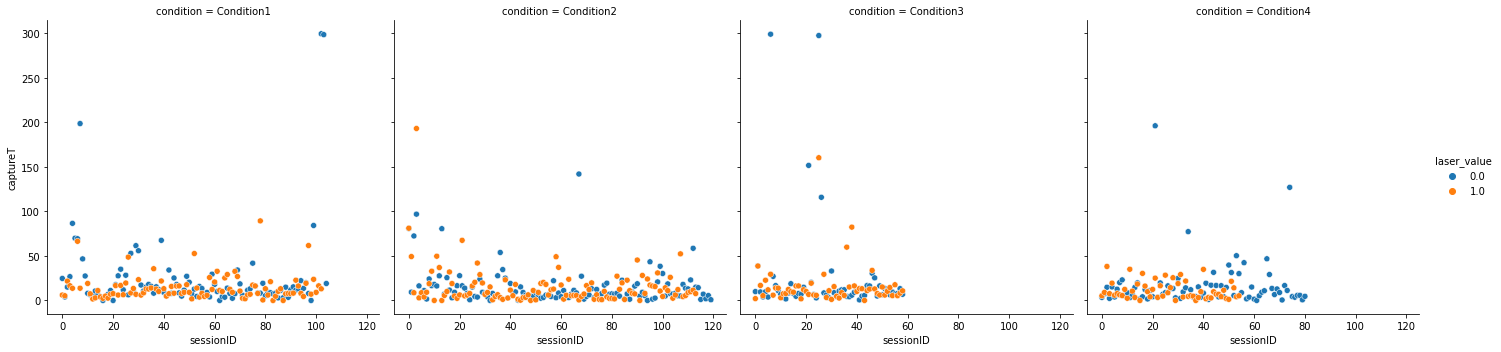

In [122]:
sns.relplot(x='sessionID', y='captureT', col='condition', hue='laser_value', data=copydf)


(0.0, 25.0)

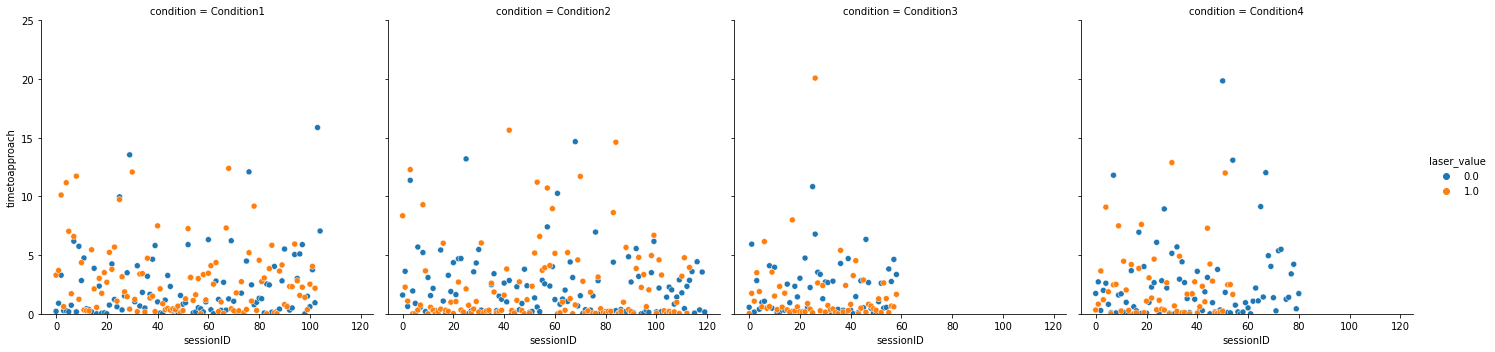

In [21]:
sns.relplot(x='sessionID', y='timetoapproach', col='condition', hue='laser_value', data=copydf)
plt.ylim(0,25)
# plt.xlim(0,20)

In [22]:
copydf.groupby(['condition','laser_value']).mean()

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                        
Condition1 0.0          24.792794      0.140954        2.476762    0.650588   
           1.0          14.429750      0.115506        2.830340    0.770205   
Condition2 0.0          15.032625      0.117598        2.161458    0.658300   
           1.0          15.337675      0.107697        2.378684    0.627408   
Condition3 0.0          24.902414      0.120615        2.000085    0.753376   
           1.0          16.154914      0.125753        1.614746    0.750816   
Condition4 0.0          16.470000      0.100648        3.823333    0.691034   
           1.0          11.277818      0.092408        2.359000    0.607886   

                        prob_capture  sessionID  
condition  laser_value                           
Condition1 0.0              0.453326       52.0  
           1.0              0.496875       51.0  
Condition2 0.0              0.662666       59.5  
           1.0              0.647536       56.5  
Condition3 0.0              0.502096       29.0  
           1.0              0.413908       29.0  
Condition4 0.0              0.599123       40.0  
           1.0              0.623485       27.0

In [11]:
condition1_0=np.arange(0,105)
condition1_1=np.arange(0,103)
condition2_0=np.arange(0,120)
condition2_1=np.arange(0,114)
condition3_0=np.arange(0,59)
condition3_1=np.arange(0,59)
condition4_0=np.arange(0,81)
condition4_1=np.arange(0,55)

In [12]:
ids=np.concatenate([condition1_0,condition1_1,condition2_0,condition2_1,condition3_0,condition3_1,condition4_0,condition4_1])

In [54]:
speedtest=copydf[['condition', 'mouse_spd', 'laser_value', 'sessionID']]

In [55]:
speedtest

,condition,mouse_spd,laser_value,sessionID
71,Condition1,"[nan, nan, nan, nan, nan, nan, nan, nan, 9.988...",0.0,0
73,Condition1,"[1.9435794273233826, 2.3150358818697847, 2.623...",0.0,1
74,Condition1,"[1.5840676417588357, 1.5447335323554987, 1.731...",0.0,2
75,Condition1,"[1.0990857586588967, 1.8790604197626206, 1.063...",0.0,3
76,Condition1,"[4.504542091130307, 4.687903667629036, 4.95473...",0.0,4
...,...,...,...,...
703,Condition4,"[1.279324311771368, 1.241758894488447, 1.30658...",1.0,50
737,Condition4,"[1.462482842239078, 1.488112138526609, 1.60963...",1.0,51
738,Condition4,"[12.066814973701607, 13.87237568286862, 16.108...",1.0,52
739,Condition4,"[0.5426251488004638, 0.6258404237519565, 0.650...",1.0,53


In [56]:

mouse_speed=np.asarray(speedtest['mouse_spd'])

In [57]:
speedtest

,condition,mouse_spd,laser_value,sessionID
71,Condition1,"[nan, nan, nan, nan, nan, nan, nan, nan, 9.988...",0.0,0
73,Condition1,"[1.9435794273233826, 2.3150358818697847, 2.623...",0.0,1
74,Condition1,"[1.5840676417588357, 1.5447335323554987, 1.731...",0.0,2
75,Condition1,"[1.0990857586588967, 1.8790604197626206, 1.063...",0.0,3
76,Condition1,"[4.504542091130307, 4.687903667629036, 4.95473...",0.0,4
...,...,...,...,...
703,Condition4,"[1.279324311771368, 1.241758894488447, 1.30658...",1.0,50
737,Condition4,"[1.462482842239078, 1.488112138526609, 1.60963...",1.0,51
738,Condition4,"[12.066814973701607, 13.87237568286862, 16.108...",1.0,52
739,Condition4,"[0.5426251488004638, 0.6258404237519565, 0.650...",1.0,53


In [52]:
np.nanmean(mouse_speed, axis=1)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [43]:
np.nanmean(mouse_speed[1])

6.18580892082296

In [44]:
np.nanmean(mouse_speed[106])

5.797331914721189

In [45]:
np.nanmean(mouse_speed[107])

7.249367211984658

In [46]:
np.nanmean(mouse_speed[108])

7.441374539566648

In [47]:
np.nanmean(mouse_speed[109])

2.9564556231695174